In [1]:
# Imports 
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformer_models import *
from transformer_data import *

In [2]:
# Helper function from homework
def pad_wav(wav, wav_max_length, pad=0):
    """Pads audio wave sequence to be `wav_max_length` long."""
    dim = wav.shape[1]
    padded = np.zeros((wav_max_length, dim)) + pad
    if len(wav) > wav_max_length:
        wav = wav[:wav_max_length]
    length = len(wav)
    padded[:length, :] = wav
    return padded, length

In [3]:
#Features we want right now: min f0, max f0, and mean f0 and maybe rms (not sure exactly what that is but was used in the paper)
from collections import defaultdict

path = '/home/CREMA-D/AudioWAV/'
files = os.listdir(path)

summary = pd.read_csv('/home/CREMA-D/processedResults/summaryTable.csv')

num_files = len(os.listdir(path)) #not sure how you want to count files
count = 0

# Aim to get to 12 features
num_features = 6
# Include mel-spectrogram as feature or not
mels = True

# Keep track of min and max duration of all data
min_dur = np.inf
max_dur = 0
max_length = 0

# Data breakdown (tally for each label)
tally = defaultdict(int)

if mels:
    X = np.zeros((num_files, num_features + 250 * 128))
else:
    X = np.zeros((num_files, num_features))
Y = np.zeros(num_files).astype(str)
for sample in tqdm(files): #depends on how you access
    file = os.path.join(path,sample)
    current_wav, current_sr = librosa.load(file) #fix for set up 
    
    # Mel spectrogram
    if mels:
        mel_spec = librosa.feature.melspectrogram(y=current_wav, sr=current_sr)
        m_log = librosa.power_to_db(mel_spec)
        m_log_norm = librosa.util.normalize(m_log)
        padded_wav, input_length = pad_wav(m_log_norm.T, 250)
        flat_mel = padded_wav.flatten()
    
    # Prosodic features
    f0_series = librosa.yin(current_wav, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
    rms_series = librosa.feature.rms(y=current_wav)
    f0_max = np.amax(f0_series)
    f0_min = np.amin(f0_series)
    # Get f0 range
    f0_range = f0_max - f0_min
    # duration
    duration = librosa.get_duration(y=current_wav, sr=current_sr)
    
    # Outer duration
    if duration > max_dur:
        max_dur = duration
    if duration < min_dur:
        min_dur = duration
        
    # Get the pitches
#     pitches, magnitudes = librosa.piptrack(y=current_wav, sr=current_sr)
#     pitch_max = np.amax(pitches)
#     pitch_min = np.amin(pitches)
#     # Get f0 range
#     pitch_range = pitch_max - pitch_min
#     pitch_mean = np.mean(pitches)
    
    f0_mean = np.mean(f0_series)
    rms_max = np.amax(rms_series)
    rms_min = np.amin(rms_series)
    rms_mean = np.mean(rms_series)
#     x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean, pitch_max, pitch_min, 
#                   pitch_range, pitch_mean])
    if num_features == 8:
        x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean])
    else:
        x = np.array([f0_min, f0_max, f0_mean, rms_min, rms_max, rms_mean])
    if mels:
        x = np.append(x, flat_mel)
    X[count,:] = x
    # Get the label for VoiceVote
    info = summary.loc[summary['FileName'] == sample.split('.')[0]]
    if not info.empty:
        tally[info['VoiceVote'].values[0]] += 1
    try:
        Y[count] = info['VoiceVote'].values[0]
    except Exception as ex:
        print(f'info: {info}')
        print(f'index count: {count}')
        index = count
        print(f'unable to find file: {sample}')
        count -= 1
    count += 1
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')

 39%|███▉      | 2913/7442 [08:25<18:28,  4.09it/s]

info: Empty DataFrame
Columns: [Unnamed: 0, FileName, VoiceVote, VoiceLevel, FaceVote, FaceLevel, MultiModalVote, MultiModalLevel]
Index: []
index count: 2912
unable to find file: 1040_ITH_SAD_X.wav


100%|██████████| 7442/7442 [21:40<00:00,  5.72it/s]

shape of train data: (7442, 32006)
shape of labels: (7442,)


In [4]:
#For Logistic Regression, can use sklearn.linear_model.LogisticRegression
# !pip install -U scikit-learn
# import sklearn
# from sklearn.linear_model import LogisticRegression
# Remove the file that wasn't in results
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')
print(Y[7440:])

# Remove that one example without a label
X = np.delete(X,-1,axis=0)
Y = Y[:-1]
print(f'New X shape: {X.shape}')
print(f'New Y shape: {Y.shape}')
print(f'Example feature: {X[4,:]}')
print(f'Last Y to check: {Y[-1]}')
print(f'min duration: {min_dur}')
print(f'max duration: {max_dur}')

# Print the tally information
print(f'Tallies of each class: {tally}')

# Find number of unique labels
num_unique = np.unique(Y).shape[0]
print(f'num classes: {num_unique}')

# Use label encoder for string labels
le = preprocessing.LabelEncoder()
le.fit(Y)
print(f'classes: {le.classes_}')
transformed_labels = le.transform(Y)
print(f'shape of transformed labels: {transformed_labels.shape}')
print(transformed_labels)

le2 = preprocessing.LabelEncoder()
check = le2.fit_transform(Y)
print(np.array_equal(transformed_labels, check))

shape of train data: (7442, 32006)
shape of labels: (7442,)
['N' '0.0']
New X shape: (7441, 32006)
New Y shape: (7441,)
Example feature: [ 72.53887284 279.62245683 154.8806316  ...   0.           0.
   0.        ]
Last Y to check: N
min duration: 1.2679818594104308
max duration: 5.005034013605442
Tallies of each class: defaultdict(<class 'int'>, {'N': 3896, 'F': 645, 'D:N': 81, 'D': 547, 'S': 370, 'H': 353, 'A': 986, 'H:N': 73, 'F:N': 93, 'A:D:N': 13, 'A:D': 73, 'N:S': 114, 'F:S': 28, 'F:H:N:S': 1, 'A:D:H:N': 1, 'F:H:N': 4, 'A:N': 38, 'D:S': 12, 'F:H': 11, 'A:D:F:N:S': 1, 'A:H:N': 5, 'A:F': 14, 'D:H': 5, 'D:F:N:S': 2, 'A:H': 10, 'D:F:N': 8, 'F:N:S': 11, 'A:F:N': 3, 'H:N:S': 3, 'D:F:S': 3, 'D:F': 17, 'D:N:S': 5, 'A:D:F:N': 4, 'A:N:S': 1, 'A:S': 3, 'D:H:N': 3, 'D:F:H:N': 1, 'H:S': 2, 'A:D:N:S': 1})
num classes: 39
classes: ['A' 'A:D' 'A:D:F:N' 'A:D:F:N:S' 'A:D:H:N' 'A:D:N' 'A:D:N:S' 'A:F' 'A:F:N'
 'A:H' 'A:H:N' 'A:N' 'A:N:S' 'A:S' 'D' 'D:F' 'D:F:H:N' 'D:F:N' 'D:F:N:S'
 'D:F:S' 'D:H' 'D:H

In [5]:
# Set up the dataloaders
train_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='train')
val_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='val')
test_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='test')

# Check dataset length
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
#print(f'test: {test_indices}')

# Check data
print(train_dataset[0])
print(test_dataset[0])

# Set dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
5952
744
745
(tensor([ 68.5731, 270.8663, 187.4343,  ...,   0.0000,   0.0000,   0.0000]), tensor([36]))
(tensor([ 68.1394, 700.5300, 204.9638,  ...,   0.0000,   0.0000,   0.0000]), tensor([36]))


In [14]:
# Load the state dict
if mels:
    model = EmotionLSTMTransformer(num_features + 250 * 128, num_unique).cuda()
else:
    model = EmotionLSTMTransformer(num_features, num_unique).cuda()
model.load_state_dict(torch.load('./Results/EmotionLSTMTransformer_0/EmotionLSTMTransformer_state_dict.pt'))

<All keys matched successfully>

In [ ]:
# Run testing on the results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()

train_indices = train_dataset.indices
val_indices = val_dataset.indices
test_indices = test_dataset.indices
X_test = X[test_indices[0]:,:]
y_test = Y[test_indices[0]:]
y_test = le.transform(y_test)

criterion = nn.NLLLoss()

correct_test = 0
test_loss = 0
total_macro = 0
total_micro = 0
y_preds = []
for i in range(len(test_indices)):
    x = torch.FloatTensor(X_test[i,:])
    y = torch.FloatTensor(y_test[i])
    x_cuda = x.cuda()
    y_cuda = torch.squeeze(y).cuda()

    # Output from mode
    # Need to be 2D for LSTM transformer
    x_cuda = torch.unsqueeze(x_cuda, 0)
    output = model(x_cuda)
    output = output.cuda()

    # Need to take max over the log probs (batch_size, num_classes)
    pred = torch.argmax(output)
    pred = pred.type(torch.FloatTensor).cuda()
    y_preds.append(pred.cpu().detach().numpy())

    num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
    correct_test += num_correct

# Accuracy
y_pred = np.array(y_preds).astype(int)
accuracy = correct_test / (len(test_indices))
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print("Test Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % (accuracy, f1_macro, f1_micro))

# Create confusion matrix for test set
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)
print(y_test[:5])
fig, ax = plt.subplots(figsize=(15, 15))
cm=confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=45)

Train Accuracy: 1.434, Avg F1 macro: 0.0339, Avg F1 micro: 0.590
['N' 'N' 'F' 'D:N' 'N']


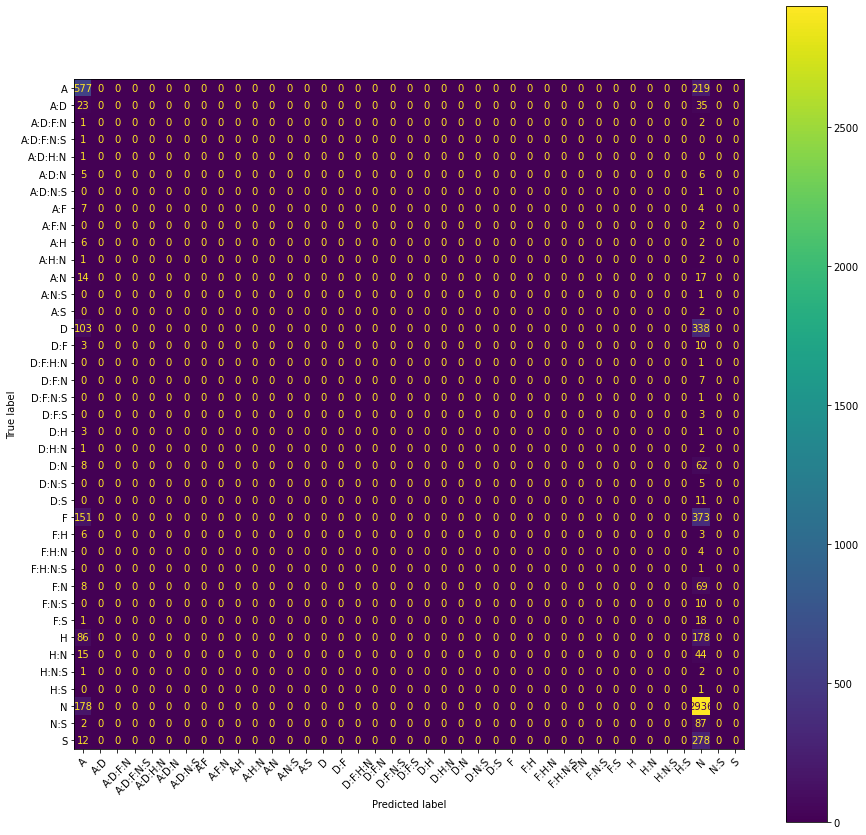

In [15]:
# Confusion matrix for train set
# Run testing on the results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()

train_indices = train_dataset.indices
val_indices = val_dataset.indices
test_indices = test_dataset.indices
X_test = X[train_indices[0]:val_indices[0],:]
y_test = Y[train_indices[0]:val_indices[0]]
y_test = le.transform(y_test)

correct_test = 0
test_loss = 0
total_macro = 0
total_micro = 0
y_preds = []
for i in range(len(train_indices)):
    x = torch.FloatTensor(X_test[i,:])
    y = torch.FloatTensor(y_test[i])
    x_cuda = x.cuda()
    y_cuda = torch.squeeze(y).cuda()

    # Output from mode
    x_cuda = torch.unsqueeze(x_cuda, 0)
    output = model(x_cuda)
    output = output.cuda()

    # Need to take max over the log probs (batch_size, num_classes)
    pred = torch.argmax(output)
    pred = pred.type(torch.FloatTensor).cuda()
    y_preds.append(pred.cpu().detach().numpy())

    num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
    correct_test += num_correct

# Accuracy
y_pred = np.array(y_preds).astype(int)
accuracy = correct_test / (len(train_indices))
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print("Train Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % (accuracy, f1_macro, f1_micro))

# Create confusion matrix for train set
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)
print(y_test[:5])
fig, ax = plt.subplots(figsize=(15, 15))
cm=confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=45)

In [ ]:
# Confusion matrix for val set
# Run testing on the results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()

train_indices = train_dataset.indices
val_indices = val_dataset.indices
test_indices = test_dataset.indices
X_test = X[val_indices[0]:test_indices[0],:]
y_test = Y[val_indices[0]:test_indices[0]]
y_test = le.transform(y_test)

correct_test = 0
test_loss = 0
total_macro = 0
total_micro = 0
y_preds = []
for i in range(len(val_indices)):
    x = torch.FloatTensor(X_test[i,:])
    y = torch.FloatTensor(y_test[i])
    x_cuda = x.cuda()
    y_cuda = torch.squeeze(y).cuda()

    # Output from mode
    #x_cuda = torch.unsqueeze(x_cuda, 0)
    output = model(x_cuda)
    output = output.cuda()

    # Need to take max over the log probs (batch_size, num_classes)
    pred = torch.argmax(output)
    pred = pred.type(torch.FloatTensor).cuda()
    y_preds.append(pred.cpu().detach().numpy())

    num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
    correct_test += num_correct

# Accuracy
y_pred = np.array(y_preds).astype(int)
accuracy = correct_test / (len(val_indices))
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print("Val Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % (accuracy, f1_macro, f1_micro))

# Create confusion matrix for val set
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)
print(y_test[:5])
fig, ax = plt.subplots(figsize=(15, 15))
cm=confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=45)

In [ ]:
# Confusion matrix for entire dataset
# Run testing on the results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()

train_indices = train_dataset.indices
val_indices = val_dataset.indices
test_indices = test_dataset.indices
X_test = X
y_test = Y
y_test = le.transform(y_test)

correct_test = 0
test_loss = 0
total_macro = 0
total_micro = 0
y_preds = []
for i in range(X.shape[0]):
    x = torch.FloatTensor(X_test[i,:])
    y = torch.FloatTensor(y_test[i])
    x_cuda = x.cuda()
    y_cuda = torch.squeeze(y).cuda()

    # Output from mode
    #x_cuda = torch.unsqueeze(x_cuda, 0)
    output = model(x_cuda)
    output = output.cuda()

    # Need to take max over the log probs (batch_size, num_classes)
    pred = torch.argmax(output)
    pred = pred.type(torch.FloatTensor).cuda()
    y_preds.append(pred.cpu().detach().numpy())

    num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
    correct_test += num_correct

# Accuracy
y_pred = np.array(y_preds).astype(int)
accuracy = correct_test / (X.shape[0])
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print("Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % (accuracy, f1_macro, f1_micro))

# Create confusion matrix for val set
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)
print(len(y_pred))
print(y_test[:5])
fig, ax = plt.subplots(figsize=(20, 20))
cm=confusion_matrix(y_test, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=45)